# GROUPE 6: TP4

# Partie 1 : Analyse exploratoire des séries temporelles

### L'objectif est de visualiser et comprendre les tendances des indices SPX et VIX.

## Importation des bibliothèques

In [44]:
!pip install tensorflow

In [45]:
!pip install pandas

In [46]:
!pip install matplotlib

In [47]:
pip install seaborn scikit-learn tensorflow keras statsmodels scipy xlrd openpyxl

Note: you may need to restart the kernel to use updated packages.


In [48]:
import sys
print(sys.version)

3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pathlib import Path
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

##  ------------------ 1. Chargement des données ------------------ #

In [50]:
# Charger les indices SPX et VIX
SPX = pd.read_csv("C:/Users/Pc/OneDrive/Bureau/Dossier/R/Donnees/SPX.txt", 
    sep="\t",  
    names=["Date", "SPX"],  
    parse_dates=["Date"],  
    index_col="Date", 
    decimal="," ) 
VIX = pd.read_csv("C:/Users/Pc/OneDrive/Bureau/Dossier/R/Donnees/VIX.txt", 
    sep="\t", 
    names=["Date", "VIX"], 
    parse_dates=["Date"], 
    index_col="Date",  
    decimal="," 
)

In [51]:
VIX .head()

,VIX
Date,
06/01/1995,13.13
13/01/1995,11.10
20/01/1995,12.15
27/01/1995,11.25
03/02/1995,10.98


In [52]:
# Vérification des valeurs manquantes
print("Valeurs manquantes par colonne:\n", SPX.isnull().sum())

Valeurs manquantes par colonne:
 SPX    0
dtype: int64


**SPX ne présente aucune valeur manquante, ce qui signifie qu'il n'y a pas de données absentes dans cette colonne. Cela facilite l'analyse, car aucune gestion des valeurs manquantes n'est nécessaire pour cette variable.**

In [53]:
# Vérification des valeurs manquantes
print("Valeurs manquantes par colonne:\n", VIX.isnull().sum())

Valeurs manquantes par colonne:
 VIX    0
dtype: int64


**VIX également, ne présente aucune valeur manquante, ce qui signifie qu'il n'y a pas de données absentes dans cette colonne.**

In [54]:
SPX.index = pd.to_datetime(SPX.index, dayfirst=True)

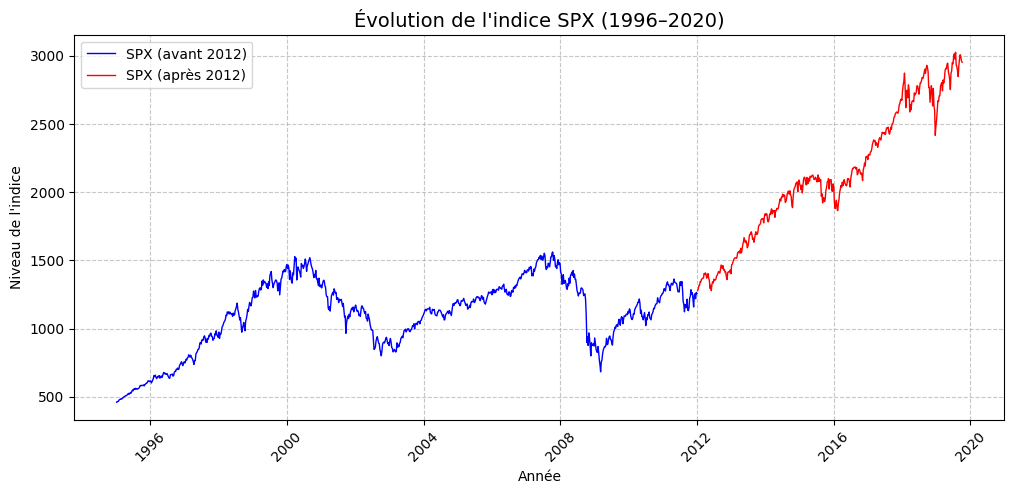

In [55]:
# Séparer train (avant 2012) et test (après 2012)
train_spx = SPX.loc[:'2011-12-31']
test_spx = SPX.loc['2012-01-01':]
# Création du graphique SPX
plt.figure(figsize=(12, 5))
plt.plot(train_spx.index, train_spx["SPX"], color="blue", linewidth=1, label="SPX (avant 2012)")
plt.plot(test_spx.index, test_spx["SPX"], color="red", linewidth=1, label="SPX (après 2012)")
plt.title("Évolution de l'indice SPX (1996–2020)", fontsize=14)
plt.ylabel("Niveau de l'indice")
plt.xlabel("Année")
plt.grid(True, linestyle="--", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)
plt.legend()
plt.show()

**Le graphique représente l’évolution de l’indice S&P 500 (SPX) entre 1996 et 2020. On observe une tendance haussière globale, bien que marquée par plusieurs cycles économiques. Avant 2012 (en bleu), l’indice traverse deux crises majeures : l’éclatement de la bulle internet (2000-2002) et la crise financière de 2008, qui entraînent des baisses significatives. Après 2012 (en rouge), l’indice connaît une phase de croissance continue, portée par la reprise économique, les politiques monétaires accommodantes et l’essor des grandes entreprises technologiques. Malgré quelques corrections, l’indice atteint de nouveaux sommets, illustrant la résilience des marchés financiers à long terme.**

In [56]:
VIX.index = pd.to_datetime(SPX.index, dayfirst=True)

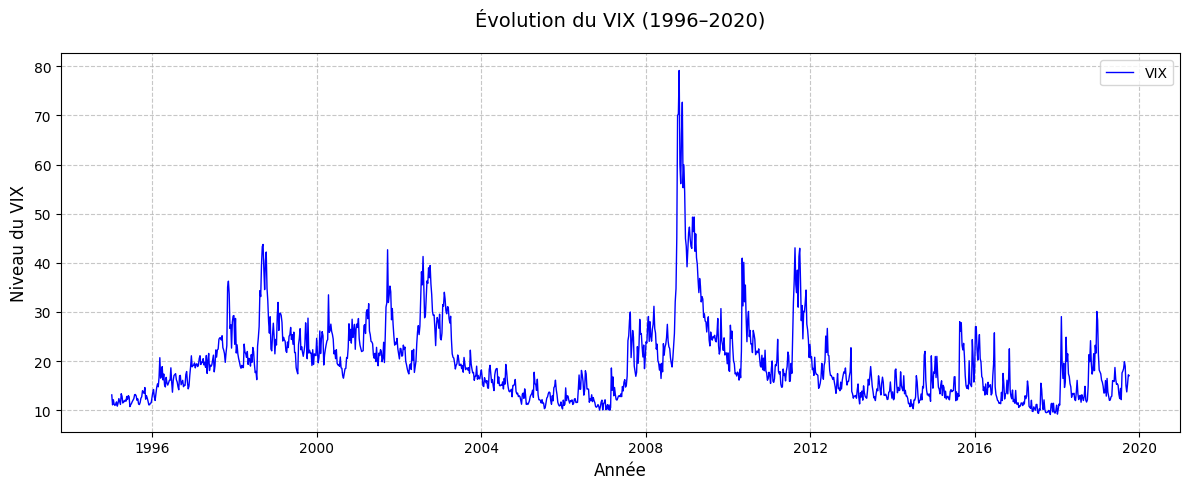

In [57]:
plt.figure(figsize=(12, 5))  # Nouvelle figure
plt.plot(VIX.index, VIX["VIX"], color="blue", linewidth=1, label="VIX")
plt.title("Évolution du VIX (1996–2020)", fontsize=14, pad=20)
plt.ylabel("Niveau du VIX", fontsize=12)
plt.xlabel("Année", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))  # Format année
plt.legend()
plt.tight_layout()

plt.show()  

**Le graphique illustre l'évolution du VIX (indice de volatilité mesurant les anticipations de risques sur les marchés financiers) entre 1996 et 2020. On observe des pics marqués lors de crises économiques majeures, comme en 2008 (crise financière mondiale) ou en 2020 (pandémie de COVID-19), où le niveau du VIX a significativement augmenté, reflétant une forte aversion au risque. Les périodes intermédiaires (ex. 2004, 2012, 2016) correspondent généralement à des phases de stabilité ou de reprise, avec un VIX plus modéré. Cette dynamique souligne le rôle du VIX comme « indicateur de peur », réagissant aux chocs géopolitiques, économiques ou sanitaires.**

# Partie 2 : Prédiction des fluctuations du SPX
### L'objectif est de prédire le rendement hebdomadaire du SPX.

In [58]:
# ------------------ 2. Préparation des données ------------------ #
# Création de la variable cible (SPX une semaine plus tard)
SPX["SPX_target"] = SPX["SPX"].shift(-5)  # Horizon de prédiction = 1 semaine


In [59]:
SPX

,SPX,SPX_target
Date,,
1995-01-06,460.68,481.46
1995-01-13,465.97,481.97
1995-01-20,464.78,488.11
1995-01-27,470.39,485.42
1995-02-03,478.64,489.57
...,...,...
2019-09-06,2978.71,NaN
2019-09-13,3007.39,NaN
2019-09-20,2992.07,NaN


In [60]:
# Suppression des lignes contenant des NaN (liées au décalage)
SPX.dropna(inplace=True)

In [61]:
SPX

,SPX,SPX_target
Date,,
1995-01-06,460.68,481.46
1995-01-13,465.97,481.97
1995-01-20,464.78,488.11
1995-01-27,470.39,485.42
1995-02-03,478.64,489.57
...,...,...
2019-08-02,2932.05,2978.71
2019-08-09,2918.65,3007.39
2019-08-16,2888.68,2992.07


In [62]:
# Séparation des données en train et test (avant/après 2012)
train = SPX.loc[:"2011-12-31"]
test = SPX.loc["2012-01-01":]

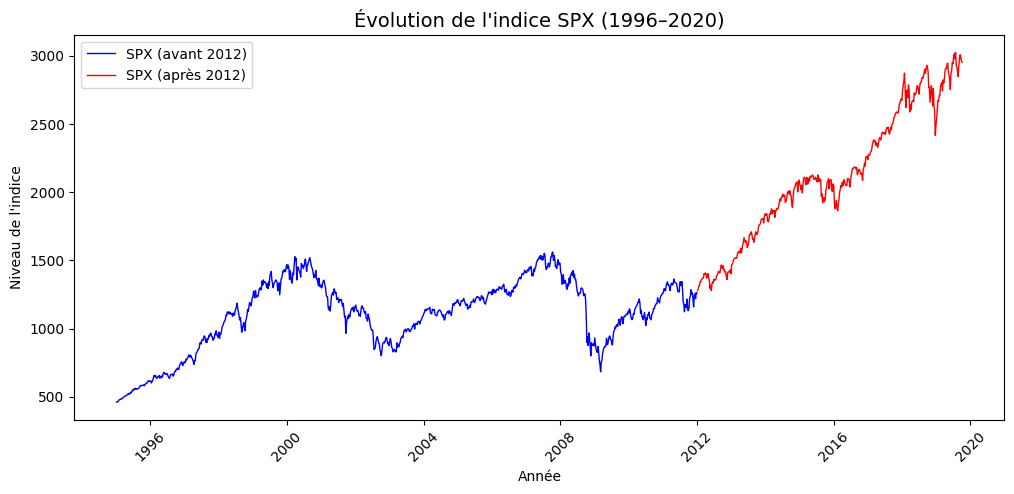

In [80]:
# Création du graphique SPX
plt.figure(figsize=(12, 5))
plt.plot(train_spx.index, train_spx["SPX"], color="blue", linewidth=1, label="SPX (avant 2012)")
plt.plot(test_spx.index, test_spx["SPX"], color="red", linewidth=1, label="SPX (après 2012)")
plt.title("Évolution de l'indice SPX (1996–2020)", fontsize=14)
plt.ylabel("Niveau de l'indice")
plt.xlabel("Année")
plt.grid(True, linestyle="", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [63]:
# Séparation des features et de la cible
X_train, y_train = train.drop(columns=["SPX_target"]), train["SPX_target"]
X_test, y_test = test.drop(columns=["SPX_target"]), test["SPX_target"]

In [66]:
# Standardisation des données
c = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
# ------------------ 3. Modélisation ------------------ #

# Modèle 1 : Régression Linéaire
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lr = lin_reg.predict(X_test_scaled)

In [69]:
y_pred_lr

array([1275.08643096, 1285.87999186, 1311.036261  , 1311.94529317,
       1339.28323951, 1337.12069983, 1354.90902403, 1359.22453464,
       1362.94678214, 1364.13330834, 1395.997278  , 1389.24173368,
       1400.11184465, 1390.16990337, 1363.549614  , 1371.46297824,
       1395.22220847, 1362.43963788, 1347.40711646, 1291.74564153,
       1313.37103836, 1275.3160812 , 1320.87294593, 1337.31207502,
       1329.82930497, 1355.79891868, 1348.64148645, 1350.65092598,
       1356.27735666, 1378.58213542, 1383.38565277, 1397.62396714,
       1409.38397276, 1402.65713472, 1398.30334908, 1428.29184185,
       1454.94083749, 1449.56319457, 1430.92325075, 1450.30955782,
       1419.36418909, 1423.76581853, 1403.43220426, 1405.59474394,
       1372.72605451, 1353.61724148, 1400.76252031, 1407.48935835,
       1409.29785393, 1405.00148084, 1420.85691559, 1394.33231382,
       1455.61065067, 1460.95001856, 1474.27930076, 1490.52705466,
       1500.29675827, 1504.85148787, 1506.63127717, 1502.62196

In [72]:
# Modèle 2 : Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [73]:
y_pred_rf

array([1264.9282, 1277.7571, 1333.8829, 1186.8208, 1260.7948, 1277.0156,
       1292.1535, 1380.4731, 1350.9807, 1391.8644, 1367.1879, 1366.7362,
       1405.2387, 1386.1316, 1400.78  , 1416.0717, 1359.9506, 1383.4591,
       1286.1151, 1324.2075, 1270.5615, 1245.3816, 1288.5686, 1328.8092,
       1327.2643, 1384.1229, 1269.0026, 1320.5602, 1397.5524, 1469.9518,
       1335.2527, 1416.1924, 1424.6364, 1400.9805, 1426.0993, 1399.0682,
       1389.988 , 1466.3499, 1430.4162, 1477.7999, 1412.2661, 1442.3155,
       1356.5434, 1388.9846, 1369.0985, 1299.8685, 1471.2085, 1464.5059,
       1424.6364, 1361.7037, 1451.8575, 1412.522 , 1386.3984, 1474.2767,
       1405.3023, 1435.5201, 1478.0008, 1445.5121, 1437.5914, 1468.8612,
       1445.5121, 1451.9563, 1458.9227, 1455.1379, 1458.9227, 1451.9563,
       1458.9227, 1455.1379, 1458.9227, 1458.9227, 1458.9227, 1458.9227,
       1458.9227, 1458.9227, 1458.9227, 1458.9227, 1458.9227, 1458.9227,
       1458.9227, 1458.9227, 1458.9227, 1458.9227, 

In [42]:
# Modèle 3 : LSTM
from tensorflow.keras.layers import Input

# Reshape des données pour LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Définition du modèle LSTM
model_lstm = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])),  # Ajout explicite de l'entrée
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),  # Dernière couche LSTM sans return_sequences
    Dropout(0.2),
    Dense(1)  # Couche de sortie
])

# Compilation et entraînement
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=16, verbose=0)

# Prédictions
y_pred_lstm = model_lstm.predict(X_test_lstm).flatten()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [74]:
y_pred_lstm

array([1263.6232, 1274.3373, 1299.1881, 1300.0829, 1326.8812, 1324.7692,
       1342.1014, 1346.2926, 1349.9031, 1351.0531, 1381.787 , 1375.2952,
       1385.7347, 1376.1879, 1350.4874, 1358.1486, 1381.0428, 1349.4115,
       1334.8031, 1280.147 , 1301.4857, 1263.8514, 1308.8578, 1324.9562,
       1317.6381, 1342.9662, 1336.0051, 1337.9608, 1343.431 , 1365.0255,
       1369.6572, 1383.3483, 1394.6139, 1388.1746, 1384.0001, 1412.6493,
       1437.9164, 1432.8312, 1415.152 , 1433.5372, 1404.1453, 1408.3406,
       1388.917 , 1390.9882, 1359.3698, 1340.846 , 1386.3585, 1392.8014,
       1394.5316, 1390.42  , 1405.5686, 1380.1881, 1438.5492, 1443.591 ,
       1456.1503, 1471.4119, 1480.5653, 1484.8275, 1486.492 , 1482.7416,
       1485.069 , 1514.517 , 1522.9958, 1519.6036, 1530.5511, 1516.3881,
       1548.0297, 1518.143 , 1542.1552, 1570.7433, 1587.8706, 1617.9104,
       1602.0052, 1585.2406, 1596.4742, 1581.6779, 1551.2106, 1563.5135,
       1586.2623, 1629.2494, 1639.8737, 1639.4806, 

In [75]:
# ------------------ 4. Évaluation des modèles ------------------ #
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    return [rmse, mae, r2]

eval_results = {
    "Linear Regression": evaluate_model(y_test, y_pred_lr, "Linear Regression"),
    "Random Forest": evaluate_model(y_test, y_pred_rf, "Random Forest"),
    "LSTM": evaluate_model(y_test, y_pred_lstm, "LSTM")
}

eval_df = pd.DataFrame(eval_results, index=["RMSE", "MAE", "R²"])
print("\nPerformance des modèles:\n", eval_df.T)

Linear Regression -> RMSE: 97.16, MAE: 79.62, R²: 0.96
Random Forest -> RMSE: 825.97, MAE: 692.53, R²: -2.03
LSTM -> RMSE: 104.22, MAE: 88.40, R²: 0.95

Performance des modèles:
                          RMSE         MAE        R²
Linear Regression   97.162074   79.619380  0.958110
Random Forest      825.973509  692.531378 -2.027269
LSTM               104.219735   88.396219  0.951803


**L'évaluation des modèles montre que la régression linéaire et le modèle LSTM offrent des performances nettement supérieures au Random Forest. En effet, la régression linéaire affiche un RMSE de 97.16, une MAE de 79.62 et un coefficient de détermination (R²) de 0.96, indiquant une très bonne capacité de prédiction avec un faible écart entre les valeurs prédites et les valeurs réelles. De son côté, le modèle LSTM présente des résultats similaires, avec un RMSE de 104.22, une MAE de 88.40 et un R² de 0.95, ce qui témoigne également d'une bonne précision malgré une légère dégradation par rapport à la régression linéaire.**

**En revanche, le modèle Random Forest affiche des performances nettement inférieures, avec un RMSE très élevé (825.97) et une MAE de 692.53, traduisant une erreur de prédiction bien plus importante. De plus, son R² négatif (-2.03) indique qu’il est moins performant qu’une simple moyenne des valeurs observées, ce qui suggère une inadéquation totale de ce modèle pour les données utilisées.**

**En conclusion, la régression linéaire semble être le modèle le plus performant pour cette tâche, suivie de près par le LSTM, tandis que le Random Forest est inadapté et génère des erreurs trop importantes.**

In [76]:
# ------------------ 5. Analyse des prévisions ------------------ #
def count_predictions(y_true, y_pred):
    pred_up = (y_pred[1:] > y_pred[:-1])
    true_up = (y_true[1:] > y_true[:-1])
    correct_up = np.sum(pred_up & true_up)
    incorrect_up = np.sum(pred_up & ~true_up)
    correct_down = np.sum(~pred_up & ~true_up)
    incorrect_down = np.sum(~pred_up & true_up)
    return correct_up, incorrect_up, correct_down, incorrect_down

count_lr = count_predictions(y_test.values, y_pred_lr)
count_rf = count_predictions(y_test.values, y_pred_rf)
count_lstm = count_predictions(y_test.values, y_pred_lstm)

print("\nPrécision des hausses/baisse prédites:")
print(f"Régression Linéaire: {count_lr}")
print(f"Random Forest: {count_rf}")
print(f"LSTM: {count_lstm}")


Précision des hausses/baisse prédites:
Régression Linéaire: (np.int64(139), np.int64(102), np.int64(58), np.int64(100))
Random Forest: (np.int64(23), np.int64(13), np.int64(147), np.int64(216))
LSTM: (np.int64(139), np.int64(102), np.int64(58), np.int64(100))


**Régression Linéaire :**

(a) Hausse prédite et bien réalisée : Le modèle a prédit une hausse qui a effectivement eu lieu 139 fois**.

(b) Hausse prédite et non réalisée : Le modèle a prédit une hausse, mais celle-ci ne s'est pas produite 102 fois.

(c) Baisse prédite et bien réalisée : Le modèle a prédit une baisse qui a effectivement eu lieu 58 fois.

(d) Baisse prédite et non réalisée : Le modèle a prédit une baisse, mais celle-ci ne s'est pas produite 100 fois.

**Random Forest :**

(a) Hausse prédite et bien réalisée : Le modèle a prédit une hausse qui a effectivement eu lieu 23 fois.

(b) Hausse prédite et non réalisée : Le modèle a prédit une hausse, mais celle-ci ne s'est pas produite 13 fois.

(c) Baisse prédite et bien réalisée : Le modèle a prédit une baisse qui a effectivement eu lieu 147 fois.

(d) Baisse prédite et non réalisée : Le modèle a prédit une baisse, mais celle-ci ne s'est pas produite 216 fois.

**LSTM :**

(a) Hausse prédite et bien réalisée : Le modèle a prédit une hausse qui a effectivement eu lieu 139 fois.

(b) Hausse prédite et non réalisée : Le modèle a prédit une hausse, mais celle-ci ne s'est pas produite 102 fois.

(c) Baisse prédite et bien réalisée : Le modèle a prédit une baisse qui a effectivement eu lieu 58 fois.

(d) Baisse prédite et non réalisée : Le modèle a prédit une baisse, mais celle-ci ne s'est pas produite 100 fois.

**Résumé :**

**Régression Linéaire et LSTM : Ces deux modèles sont cohérents dans leurs prévisions. Ils prédisent des hausses avec une bonne précision (139 bonnes prédictions sur 241) et des baisses avec un bon taux de succès également (58 bonnes prédictions sur 158).**

**Random Forest : Ce modèle présente des résultats beaucoup plus déséquilibrés. Il prédit une baisse de manière très fréquente (147 bonnes prédictions), mais il prédit très rarement une hausse correcte (23 bonnes prédictions). Cela suggère une tendance à surestimer les baisses, ce qui le rend moins fiable pour la prédiction des rendements du SPX.
Cela montre que les modèles régression linéaire et LSTM sont plus équilibrés et mieux adaptés à cette tâche, tandis que le modèle Random Forest semble avoir des biais dans ses prédictions.**